# Classification des données en utilisant le SVM

## Importation des données

In [1]:
import pymongo
import sklearn as sk
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["Tweet"]
user_collection = db["users_labeled"]

In [3]:
%store -r nb_composante
%store -r users
%store -r cp_liste

#acp = PCA(n_components=nb_composante)
#acp_coord = acp.fit_transform(users)

no stored variable or alias cp_liste


In [53]:
users.head()

,verified,statuses_count,favourites_count,friends_count,followers_count,age_account,ratio_friends_followers,nb_sensitive_tweets,Ap,visibility,ratio_sensitive_tweets,ratio_punctuation_tweets,avg_tweet_levenshtein_similarity
user_id,,,,,,,,,,,,,
39084553,-0.099526,0.357707,0.393216,-0.009038,-0.025687,1.530497,-0.162062,-0.045764,-0.074551,0.370611,-0.102769,-0.197897,-0.682673
1564678657,-0.099526,0.266102,0.302341,-0.037677,-0.022633,0.072179,-0.258039,-0.045764,0.130840,-1.568223,-0.102769,1.890522,-0.682673
4872447178,-0.099526,-0.308945,-0.390708,0.474344,-0.006698,-0.837542,-0.207497,-0.045764,-0.200301,0.032044,-0.102769,-0.743051,1.096276
967244973824339968,-0.099526,-0.332068,-0.300332,-0.169006,-0.030090,-1.562058,-0.186954,-0.045764,0.863667,-1.183374,-0.102769,3.206349,-0.012866
35628099,-0.099526,-0.424586,-0.346223,-0.094750,-0.029972,1.543672,0.747042,-0.045764,-0.398424,1.140308,-0.102769,-0.197897,-0.682673


In [4]:
users_lab = list(user_collection.find({}))
users_lab = pd.DataFrame(users_lab)

In [5]:
#attributs_to_drop = ['suspicious_score', 'suspicious_fields', 'user_id', "friends_count","followers_count","tweet_frequency"]
attributs_to_drop = ['suspicious_score', 'suspicious_fields', 'user_id']
users_lab = users_lab.drop(columns=attributs_to_drop)
print(users_lab.columns)

Index(['_id', 'label', 'Ap', 'age_account', 'avg_tweet_length',
       'avg_tweet_levenshtein_similarity', 'favourites_count',
       'followers_count', 'friends_count', 'hashtag_frequency',
       'nb_sensitive_tweets', 'ratio_friends_followers',
       'ratio_punctuation_tweets', 'ratio_sensitive_tweets', 'statuses_count',
       'tweet_frequency', 'verified', 'visibility'],
      dtype='object')


In [6]:
Y=users_lab.label
X=users_lab.drop(columns=["label", "_id"])
attributs=[att for att in X.columns]

## Quelques statistiques sur nos utilisateurs précédemment labellisés
En examinant la distribution de chaque attribut nous sommes en mesure d'identifier les tendances et les schémas qui se dégagent.Cette démarche vise à obtenir une compréhension approfondie/préliminaire des caractéristiques de nos utilisateurs atypique et non.

Nous allons dans un premier temps récupérer les données non standardisé de nos utilisateur labélisé.

In [ ]:
pipeline = [
  {
    "$project": {
      "label": 1,
    }
  },
  {
    "$lookup": {
      "from": "users",
      "localField": "_id",
      "foreignField": "_id",
      "as": "merged_info"
    }
  },
  {
    "$unwind": {
      "path": "$merged_info",
      "preserveNullAndEmptyArrays": True
    }
  },
  {
    "$replaceRoot": {
      "newRoot": {
        "$mergeObjects": [
          "$merged_info",
          "$$ROOT"
        ]
      }
    }
  },
  {
    "$project": {
      "merged_info": 0,
      "tweet_ids": 0,
      "last_tweet_published_id": 0,
      "user_id": 0
    }
  }
]

In [ ]:
users_labeled_with_original_values = user_collection.aggregate(pipeline)

In [ ]:
users_labeled_with_original_values = list(users_labeled_with_original_values)

Ensuite, on visualise sous la forme d'un histogramme multiple la distribution de chaque attribut en fonction de leur label.

L'histogramme multiple est créé en superposant deux histogrammes, l'un pour les données ayant le label 0 et l'autre pour les données ayant le label 1. Chaque attribut est représenté sur l'axe des x, et le nombre d'occurrences est représenté sur l'axe des y. Les données correspondantes à chaque label sont colorées différemment pour une meilleure distinction visuelle.

En visualisant ces histogrammes, nous pouvons observer la répartition des valeurs pour chaque attribut en fonction de leur label. Cela nous permet de déceler des différences potentielles dans la distribution des données entre les deux catégories. Par exemple, nous pourrions identifier des attributs qui ont des valeurs plus élevées ou plus basses pour un label particulier, ce qui pourrait être utile pour comprendre les caractéristiques distinctives de chaque catégorie.

In [ ]:
label_0_data = [doc for doc in users_labeled_with_original_values if doc['label'] == 0]
label_1_data = [doc for doc in users_labeled_with_original_values if doc['label'] == 1]

# Liste des attributs à visualiser (à adapter en fonction de vos besoins)
attributes = list(users_labeled_with_original_values[0].keys())
attributes.remove('_id')
attributes.remove('label')

# Couleurs pour les deux catégories de labels
colors = ['blue', 'red']

# Création de la grille de graphiques avec deux colonnes
fig, axes = plt.subplots(nrows=len(attributes)//2, ncols=2, figsize=(20, 50))

# Création de l'histogramme multiple
for i, attr in enumerate(attributes):
    ax = axes[i//2][i%2]

    ax.hist([doc[attr] for doc in label_0_data], bins=10, alpha=0.5, color=colors[0], label='Normal')
    ax.hist([doc[attr] for doc in label_1_data], bins=10, alpha=0.5, color=colors[1], label='Atypique')
    ax.set_xlabel(attr)
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.legend()
    
plt.tight_layout()
plt.show()

## Séparation des données labélisées en Apprentisage , Test et Validation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

## Classification avec SVM

### Déterminaison de la meilleure combinaison d'hyperparamètres

Définition d'une fonction pour afficher une matrice de confusion

In [8]:
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    # Création de la figure
    fig, ax = plt.subplots()

    # Création de la heatmap
    heatmap = ax.imshow(cm, cmap='Blues')

    # Ajout des valeurs dans les cellules de la heatmap
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='black')

    # Définition des étiquettes des axes
    classes = ['Normal', 'Atypique']
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    # Ajout d'une barre de couleur
    cbar = ax.figure.colorbar(heatmap, ax=ax)

    # Ajout des titres
    ax.set_xlabel('Prédictions')
    ax.set_ylabel('Vraies étiquettes')
    ax.set_title('Matrice de confusion')

    # Affichage de la figure
    plt.show()


Définition des hyperparamètres à essayer

In [9]:
parameters = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [1e-2, 1e-1, 1, 1e1],
    'gamma': ['scale', 'auto']
}

Dans notre cas où la classe négative représente environ 84% des échantillons, utiliser le rappel seul pourrait être trompeur. Le rappel mesure la capacité d'un modèle à identifier correctement les échantillons positifs parmi tous les échantillons positifs réels. 

En utilisant ``balanced_accuracy``, on donne une importance égale aux performances des deux classes. Cela permet de s'assurer que notre modèle ne se concentre pas uniquement sur la classe majoritaire (négatif), mais qu'il est également capable de prédire correctement la classe minoritaire (postive). 

Instanciations

In [ ]:
svmc = SVC()
grille = GridSearchCV(estimator=svmc, param_grid=parameters, scoring='balanced_accuracy', cv=2, verbose=3)

Exécuter la recherche de grille pour trouver la meilleure configuration de modèle en ajustant les modèles sur les données d'apprentissage et en évaluant leur performance à l'aide de la validation croisée

In [ ]:
resultats = grille.fit(X_train, y_train)

Affichage du meilleur modèle

In [ ]:
print('Le meilleur modèle :', resultats.best_params_)

In [ ]:
resultats.cv_results_ 

In [ ]:
svm = resultats.best_estimator_
y_true = y_test
y_pred = svm.predict(X_test)

In [ ]:
display_confusion_matrix(y_true, y_pred)

In [ ]:
accuracy_score(y_true,y_pred)

In [ ]:
print(classification_report(y_true,y_pred))

Affichage des moyennes des scores de la cross validation sous la forme d'une heatmap.

In [ ]:
# Résultats du GridSearchCV
results = grille.cv_results_

# Paramètres à afficher sur l'axe des x et des y
C_values = parameters['C']
gamma_values = parameters['gamma']
kernels = parameters['kernel']

# Nombre de kernels et de paramètres sur l'axe des x (C)
n_kernels = len(kernels)
n_C_values = len(C_values)

# Création de la figure
fig, axs = plt.subplots(nrows=n_kernels // 2, ncols=2, figsize=(10, 8))

tuples_list = [(score, params) for score, params in zip(results['mean_test_score'], results['params'])]

# Création des heatmaps pour chaque kernel
for i, kernel in enumerate(kernels):
    # Calcul de l'indice de la facette (subplot)
    row = i // 2
    col = i % 2
    
    # Création d'un dictionnaire pour stocker les scores par combinaison de gamma et C pour un kernel donné
    score_dict = {(params['gamma'], params['C']): score for score, params in tuples_list if params['kernel'] == kernel}
    # Calcul des scores moyens pour chaque combinaison de gamma et C
    scores = [[score_dict.get((gamma, c), None) for c in C_values] for gamma in gamma_values]
    # Création de la heatmap
    ax = axs[row, col]
    heatmap = ax.imshow(scores, cmap='Blues', origin='lower')

    # Ajout des valeurs dans les cellules de la heatmap
    for j, gamma in enumerate(gamma_values):
        for k, c in enumerate(C_values):
            score = scores[j][k]
            if score is not None:
                ax.text(k, j, f'{score:.3f}', ha='center', va='center', color='black')

    # Définition des étiquettes des axes + titre
    ax.set_xticks(range(len(C_values)))
    ax.set_yticks(range(len(gamma_values)))
    ax.set_xticklabels(C_values)
    ax.set_yticklabels(gamma_values)
    ax.set_xlabel('C')
    ax.set_ylabel('gamma')
    ax.set_title(kernel)

# Ajustement des espacements entre les sous-graphiques
plt.tight_layout()

# Ajout de la barre de couleur commune
cbar = fig.colorbar(heatmap, ax=axs.ravel().tolist(), shrink=0.6)
cbar.set_label('Score moyen')

# Affichage de la figure
plt.show()


On regarde si on aurait obtenu de meilleurs résultats/un autre meilleur kernel avec d'autres fonctions de scoring pour le GridSearch

In [ ]:
def test_scoring_value(scoring):
    print('>>> Scoring => ', scoring)
    # determination du meilleur kernel pour la fonction de scoring
    svmc = SVC()
    grille = GridSearchCV(estimator=svmc, param_grid=parameters, scoring=scoring, cv=2)
    resultats = grille.fit(X_train, y_train)
    print('Le meilleur modèle :', resultats.best_params_)
    
    # confusion matrix & accuracy
    svm = resultats.best_estimator_
    y_true = y_test
    y_pred = svm.predict(X_test)
    print(confusion_matrix(y_true, y_pred))
    print(accuracy_score(y_true,y_pred))

In [ ]:
scorings = ['accuracy', 'balanced_accuracy', 'top_k_accuracy', 'average_precision', 'neg_brier_score', 'f1', 'neg_log_loss', 'precision', 'recall', 'jaccard', 'roc_auc']
for s in scorings:
    test_scoring_value(s)

###  Vérification des performances du modèle

Récupération des hyperparamètres optimaux

In [10]:
try:
    C_opti = resultats.best_params_['C']
    kernel_opti = resultats.best_params_['kernel']
    gamma_opti = resultats.best_params_['gamma']
except:
    C_opti = 10
    kernel_opti = 'rbf'
    gamma_opti = 'auto'

0.014833333333333365


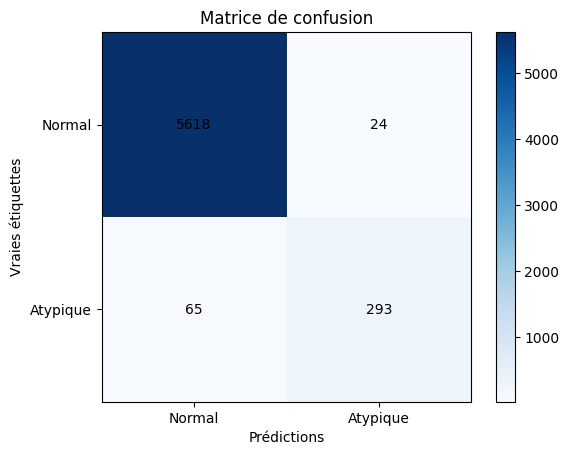

In [11]:
svm=SVC(C=C_opti,kernel=kernel_opti, gamma=gamma_opti)
svm.fit(X_train, y_train)
y_pred=svm.predict(X_test)
y_true = y_test
erreur=1-accuracy_score(y_test,y_pred)
print(erreur)

display_confusion_matrix(y_true, y_pred)

In [12]:
accuracy_score(y_true,y_pred)

0.9851666666666666

In [13]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5642
           1       0.92      0.82      0.87       358

    accuracy                           0.99      6000
   macro avg       0.96      0.91      0.93      6000
weighted avg       0.98      0.99      0.98      6000



## Prédictions sur les utilisateurs non labellisés

Nous cherchons à attribuer des labels aux utilisateurs qui n'ont pas encore été labellisés. 

Dans un premier temps, nous allons récupérer les identifiants des utilisateurs déjà labellisés afin de filtrer uniquement ceux qui n'ont pas encore été étiquetés.

In [70]:
id_labeled_users = users_lab['_id'].tolist()
len(id_labeled_users)

20000

Après avoir obtenu la liste des identifiants des utilisateurs déjà labellisés, nous procédons ensuite à la récupération des utilisateurs qui ne figurent pas dans cette liste. 

En d'autres termes, nous filtrons les utilisateurs en excluant ceux qui ont un identifiant présent dans la liste précédemment obtenue.

In [71]:
users_scaled_collection = db["users_scaled"]
filtre = {'_id': {'$nin': id_labeled_users}}
unlabeled_users = users_scaled_collection.find(filtre)

Nous allons créer une nouvelle base de données destinée à stocker les utilisateurs nouvellement labélisés. Cette base de données servira à stocker les informations des utilisateurs, y compris les labels qui leur ont été attribués.

In [72]:
user_predicted_collection = db["users_predicted"]

On supprime toute la collection pour supprimer par la même occasion les données qu'elle contient.

In [66]:
user_predicted_collection.drop()

Nous allons définir une fonction qui permet de prédire les labels pour un ensemble d'utilisateurs, puis de les insérer dans la nouvelle collection avec leur label. Cette fonction prend en paramètres les utilisateurs non labélisés.

In [73]:
def user_labeling(unlabeled_users):
    df_batch = pd.DataFrame(unlabeled_users)
    X_batch = df_batch.loc[:, X.columns]
    
    #X_pca = pca.transform(X_batch)[:, :n_components]
    labels_pred = svm.predict(X_batch)
    
    for i, user in enumerate(unlabeled_users):
        user['label'] = labels_pred[i].item()

    user_predicted_collection.insert_many(unlabeled_users)

Nous itérons à travers les utilisateurs non labellisés, en leur attribuant des labels à l'aide du SVM préalablement entraîné, puis nous insérons les utilisateurs labellisés par lots dans cette nouvelle collection. Ces opérations sont effectuées à l'aide de la fonction définit dans la cellule précédente.

In [74]:
batch_size = 100_000
nb_batch = 0
users_batch = []

for i,user in enumerate(unlabeled_users):
    users_batch.append(user)
    if len(users_batch) >= batch_size:
        user_labeling(users_batch)
        users_batch = []
        nb_batch += 1
        print(f'processed {nb_batch*batch_size} users')
        
if len(users_batch) > 0:
    user_labeling(users_batch)

print('END')

processed 100000 users
processed 200000 users
processed 300000 users
processed 400000 users
processed 500000 users
processed 600000 users
processed 700000 users
processed 800000 users
processed 900000 users
processed 1000000 users
processed 1100000 users
processed 1200000 users
processed 1300000 users
processed 1400000 users
processed 1500000 users
processed 1600000 users
processed 1700000 users
processed 1800000 users
END


## Représentation graphique (temporaire)

### Test de toutes les combinaisons : 3 axes

L'ACP ne nous a pas fournit trois axes principaux pertinents pour visualiser les données, nous avons alors décidé d'explorer toutes les combinaisons de trois axes afin de trouver la meilleure représentation graphique. Cette approche itérative peut révéler des structures et des relations complexes qui n'auraient pas été détectées autrement, bien que cela puisse demander plus de temps et de ressources.

Récupération des données prédites

In [14]:
user_predicted_collection = db["users_predicted"]
users_predicted = list(user_predicted_collection.find({}))
users_predicted = pd.DataFrame(users_predicted)

In [15]:
Y_prediction = users_predicted.label
X_prediction = users_predicted.loc[:, X.columns]

Définition des données à visualiser

In [16]:
X_visu = pd.concat([X, X_prediction])
Y_visu = pd.concat([Y, Y_prediction])

On récupère les attributs qui seront sur les axes

In [24]:
attributs = X_visu.columns.to_list()
attributs

['Ap',
 'age_account',
 'avg_tweet_length',
 'avg_tweet_levenshtein_similarity',
 'favourites_count',
 'followers_count',
 'friends_count',
 'hashtag_frequency',
 'nb_sensitive_tweets',
 'ratio_friends_followers',
 'ratio_punctuation_tweets',
 'ratio_sensitive_tweets',
 'statuses_count',
 'tweet_frequency',
 'verified',
 'visibility']

On détermine l'ensemble des couples de 3 axes possibles

In [25]:
couples_axes = list(combinations(attributs, 3))

In [26]:
couples_axes

[('Ap', 'age_account', 'avg_tweet_length'),
 ('Ap', 'age_account', 'avg_tweet_levenshtein_similarity'),
 ('Ap', 'age_account', 'favourites_count'),
 ('Ap', 'age_account', 'followers_count'),
 ('Ap', 'age_account', 'friends_count'),
 ('Ap', 'age_account', 'hashtag_frequency'),
 ('Ap', 'age_account', 'nb_sensitive_tweets'),
 ('Ap', 'age_account', 'ratio_friends_followers'),
 ('Ap', 'age_account', 'ratio_punctuation_tweets'),
 ('Ap', 'age_account', 'ratio_sensitive_tweets'),
 ('Ap', 'age_account', 'statuses_count'),
 ('Ap', 'age_account', 'tweet_frequency'),
 ('Ap', 'age_account', 'verified'),
 ('Ap', 'age_account', 'visibility'),
 ('Ap', 'avg_tweet_length', 'avg_tweet_levenshtein_similarity'),
 ('Ap', 'avg_tweet_length', 'favourites_count'),
 ('Ap', 'avg_tweet_length', 'followers_count'),
 ('Ap', 'avg_tweet_length', 'friends_count'),
 ('Ap', 'avg_tweet_length', 'hashtag_frequency'),
 ('Ap', 'avg_tweet_length', 'nb_sensitive_tweets'),
 ('Ap', 'avg_tweet_length', 'ratio_friends_followers')

Affichage du graphique correspondant pour chaque combinaison d'axes

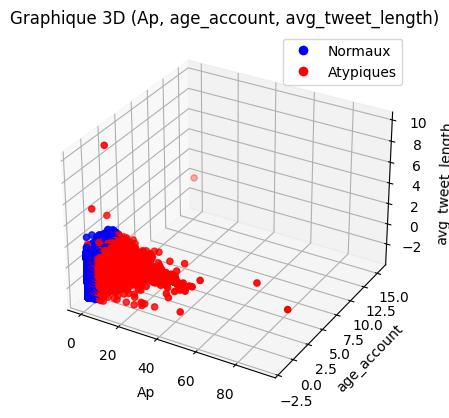

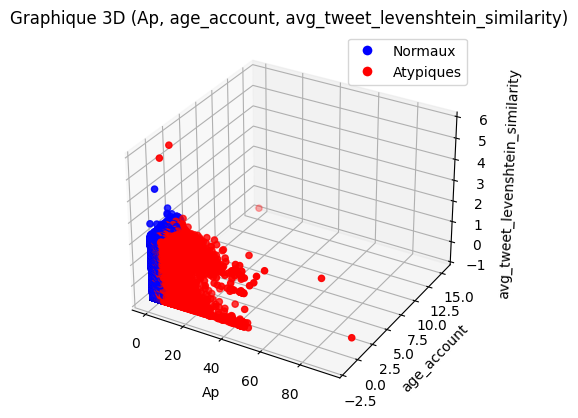

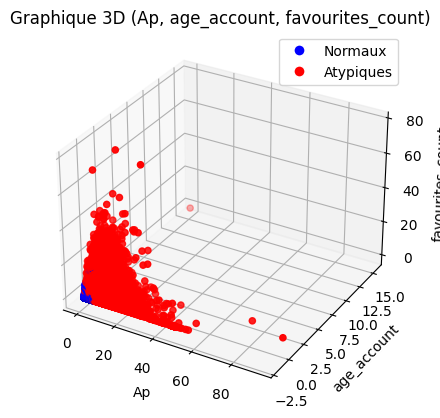

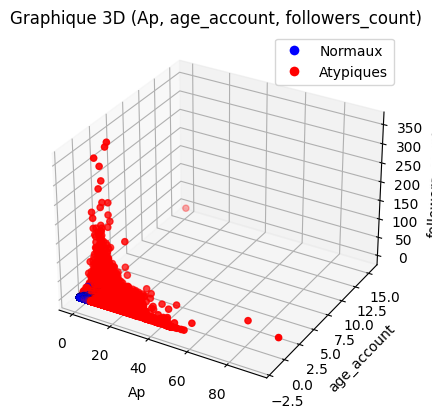

In [28]:
# Création des graphiques 3D pour chaque combinaison d'axes
for couple in couples_axes:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extraire les colonnes correspondant au couple d'axes
    x = X_visu[couple[0]]
    y = X_visu[couple[1]]
    z = X_visu[couple[2]]

    # Déterminer les couleurs en fonction de la liste Y
    colors = ['blue' if label == 0 else 'red' for label in Y_visu]

    # Créer le graphique 3D
    ax.scatter(x, y, z, c=colors)

    # Étiquettes des axes
    ax.set_xlabel(couple[0])
    ax.set_ylabel(couple[1])
    ax.set_zlabel(couple[2])

    # Titre du graphique
    title = f"Graphique 3D ({couple[0]}, {couple[1]}, {couple[2]})"
    ax.set_title(title)
    
    # Légende
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Normaux', markerfacecolor='blue', markersize=8),
                       plt.Line2D([0], [0], marker='o', color='w', label='Atypiques', markerfacecolor='red', markersize=8)]
    ax.legend(handles=legend_elements)

    # Afficher le graphique
    plt.show()

### Test de toutes les combinaisons : 3 composantes principales

#### ACP

In [20]:
nb_composante=6

pca = PCA(n_components=nb_composante)

X_pca = pca.fit_transform(X_visu)


In [21]:
column_names = ['cp1', 'cp2', 'cp3', 'cp4', 'cp5','cp6']

# Création du DataFrame
X_pca2 = pd.DataFrame(X_pca, columns=column_names)
print(X_pca2.head())

        cp1       cp2       cp3       cp4       cp5       cp6
0  0.225700  0.516498 -0.452564  0.123182  0.981396 -0.957634
1  0.104595 -2.644470  1.721124 -0.886924 -0.247221  0.174922
2 -0.255520  0.793864 -1.034902  0.385748 -0.184409  0.153819
3  0.437179 -2.269591  2.849656 -1.424748 -1.460715  1.199764
4 -0.785173  1.204747 -0.374895  0.145932  0.688279 -0.450122


In [22]:
couples_axes = list(combinations(column_names, 3))
print(len(couples_axes))
print(couples_axes)

20
[('cp1', 'cp2', 'cp3'), ('cp1', 'cp2', 'cp4'), ('cp1', 'cp2', 'cp5'), ('cp1', 'cp2', 'cp6'), ('cp1', 'cp3', 'cp4'), ('cp1', 'cp3', 'cp5'), ('cp1', 'cp3', 'cp6'), ('cp1', 'cp4', 'cp5'), ('cp1', 'cp4', 'cp6'), ('cp1', 'cp5', 'cp6'), ('cp2', 'cp3', 'cp4'), ('cp2', 'cp3', 'cp5'), ('cp2', 'cp3', 'cp6'), ('cp2', 'cp4', 'cp5'), ('cp2', 'cp4', 'cp6'), ('cp2', 'cp5', 'cp6'), ('cp3', 'cp4', 'cp5'), ('cp3', 'cp4', 'cp6'), ('cp3', 'cp5', 'cp6'), ('cp4', 'cp5', 'cp6')]


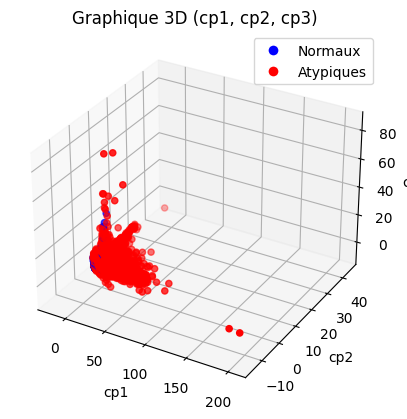

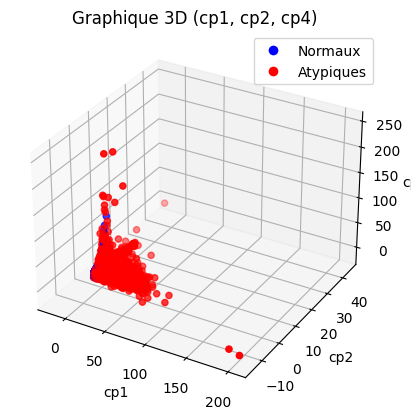

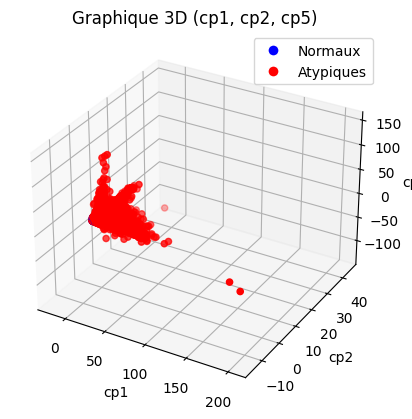

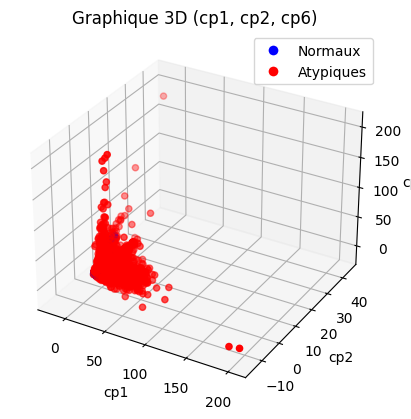

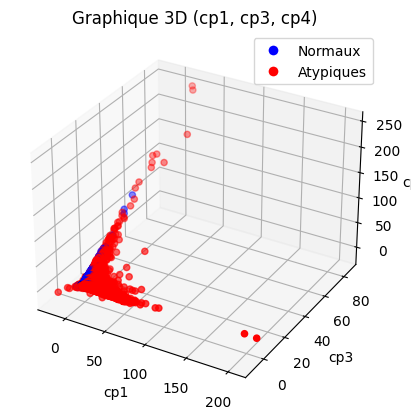

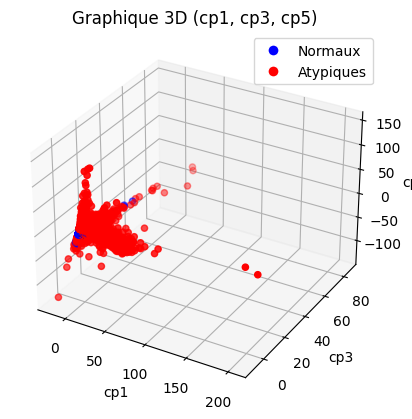

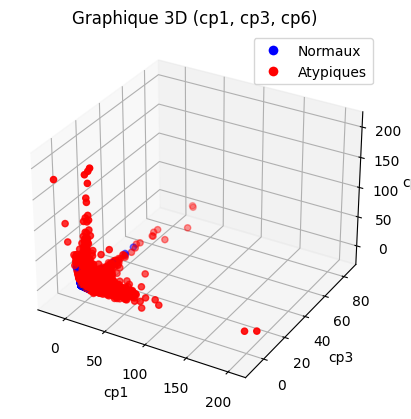

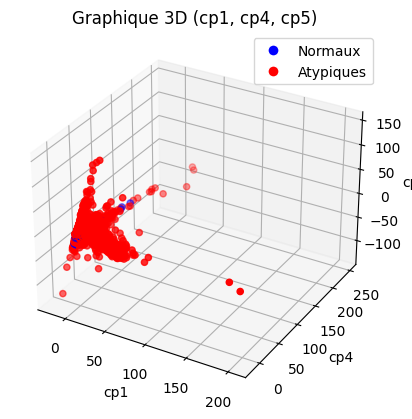

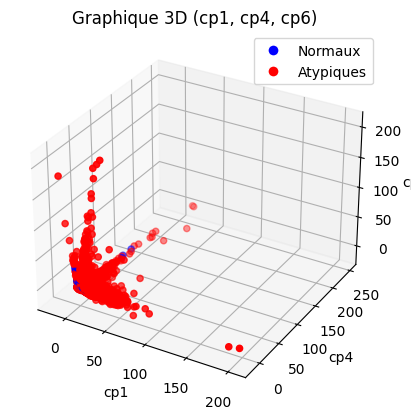

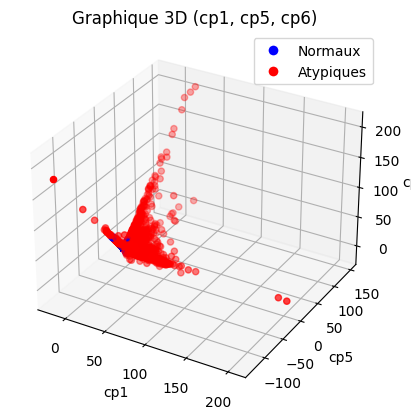

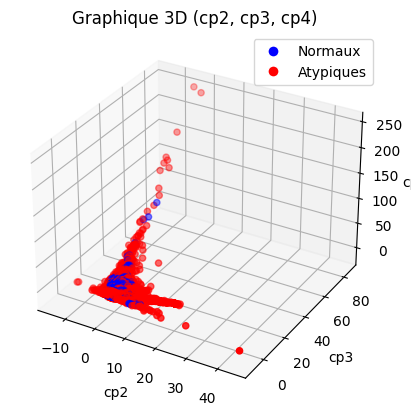

MemoryError: Unable to allocate 56.3 MiB for an array with shape (1843439, 4) and data type float64

<Figure size 640x480 with 1 Axes>

MemoryError: Unable to allocate 14.1 MiB for an array with shape (1843439,) and data type float64

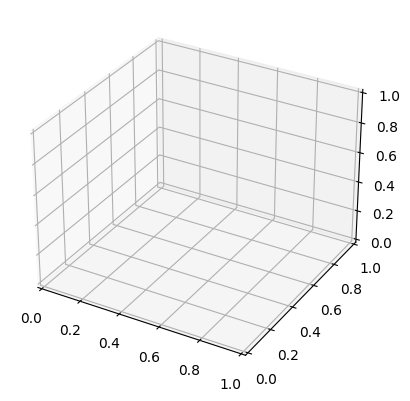

In [23]:
# Création des graphiques 3D pour chaque combinaison d'axes
for couple in couples_axes:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extraire les colonnes correspondant au couple d'axes
    x = X_pca2[couple[0]]
    y = X_pca2[couple[1]]
    z = X_pca2[couple[2]]

    # Déterminer les couleurs en fonction de la liste Y
    colors = ['blue' if label == 0 else 'red' for label in Y_visu]

    # Créer le graphique 3D
    ax.scatter(x, y, z, c=colors)

    # Étiquettes des axes
    ax.set_xlabel(couple[0])
    ax.set_ylabel(couple[1])
    ax.set_zlabel(couple[2])

    # Titre du graphique
    title = f"Graphique 3D ({couple[0]}, {couple[1]}, {couple[2]})"
    ax.set_title(title)
    
    # Légende
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Normaux', markerfacecolor='blue', markersize=8),
                       plt.Line2D([0], [0], marker='o', color='w', label='Atypiques', markerfacecolor='red', markersize=8)]
    ax.legend(handles=legend_elements)

    # Afficher le graphique
    plt.show()